# Annulus

## 0 Packages

In [1]:
from mpi4py import MPI
from dolfinx import fem, plot, mesh, io
from dolfinx.fem.petsc import LinearProblem
from basix.ufl import element, mixed_element
import pyvista
from ufl import TestFunction, TrialFunction, FacetNormal, Identity, grad, div, inner, dx, ds, transpose, dot, as_vector, outer, lhs, rhs, TestFunctions, TrialFunctions, split, nabla_grad, derivative
pyvista.set_jupyter_backend("static")
import numpy as np
from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc, NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

## 1 Generate mesh

It's easier for me to use the gmsh GUI to generate mesh. Much less code and can see how the mesh evolves with edits. I will use this method for future mesh generation.

In [22]:
# load from .msh file
mesh_file = "periodic.msh"
domain, cell_tags, facet_tags = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'periodic.msh'...
Info    : 9 entities
Info    : 510 nodes
Info    : 1018 elements
Info    : Done reading 'periodic.msh'


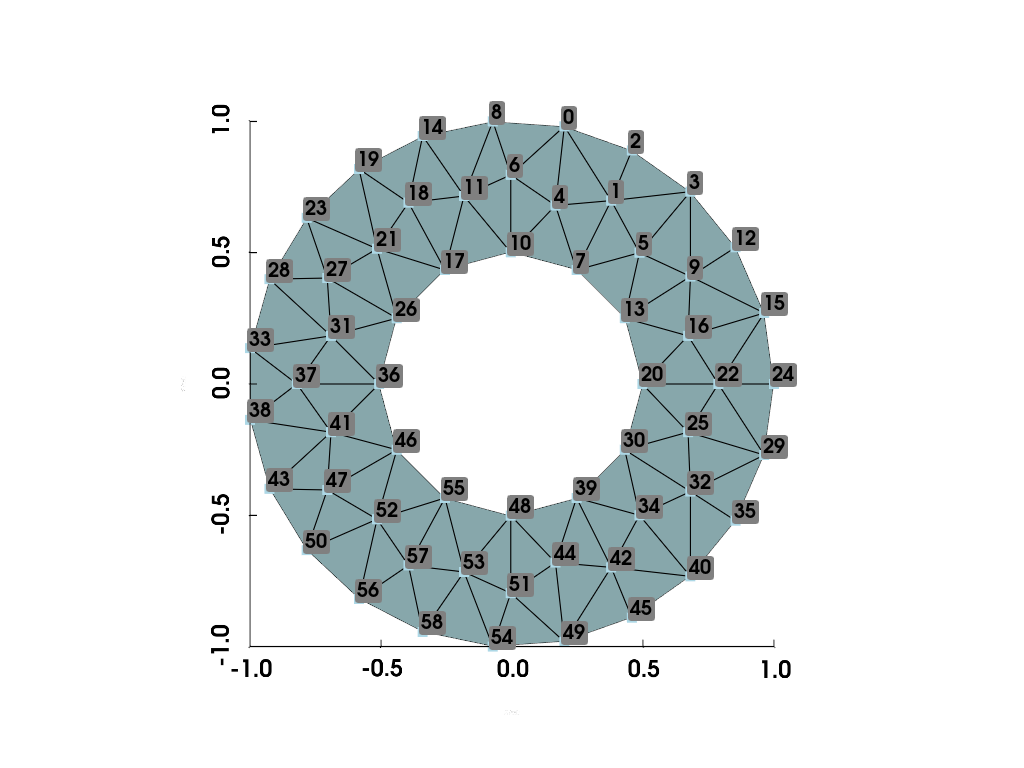

In [6]:
vtk_mesh = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(*vtk_mesh)
pl = pyvista.Plotter()
pl.add_mesh(grid, show_edges=True)
pl.add_point_labels(grid.points, [str(i) for i in range(grid.n_points)], point_size=10, font_size=20)
pl.camera_position = 'xy'
pl.show_bounds()
pl.show()

## 2 Theoretical formulation

1. Momentum Conservation

$$
\mu\nabla^2 \mathbf{u} - \nabla p = \alpha \nabla\cdot Q
$$

$$
\nabla\cdot \mathbf{u} = 0
$$

2. Q-tensor Evolution

$$
\partial_t \mathbf{Q} + \mathbf{u}\cdot\nabla\mathbf{Q} = \mathbf{Q\Omega-\Omega Q} + \lambda\mathbf{E} + \gamma^{-1}\mathbf{H}
$$

where
- $\mathbf{E} = (\nabla\mathbf{u}+\nabla\mathbf{u}^T)/2$ is the strain rate tensor 
- $\mathbf{\Omega} = (\nabla\mathbf{u}-\nabla\mathbf{u}^T)/2$ is the vorticity tensor
- $\mathbf{H} = -\delta\mathcal{F}  / \delta \mathbf{Q}$ is the molecular field
- $\lambda$: flow-alignment parameter
- $\gamma$: rotational viscosity

3. Landau - de Gennes functional

$$
\mathcal{F}_\mathrm{bulk} =  -\frac{Cb_1}{2}\mathbf{Q:Q} + \frac{Cb_2}{4}(\mathbf{Q:Q})^2 + \frac{K}{2}\nabla\mathbf{Q}:\nabla\mathbf{Q}   
$$

Surface anchoring

$$
\mathcal{F}_\mathrm{surf} =  \frac{1}{2} E_A' (\mathbf{Q} -\mathbf{Q}^{(b)}):(\mathbf{Q} -\mathbf{Q}^{(b)}) 
$$

with homeotropic boundary condition:

$$
\mathbf{Q}^{(b)} = (\hat n \otimes \hat n - \frac{1}{2} \mathbf{I}) \quad \mathrm{for} \quad x \in \partial\Omega 
$$

where $\hat n$ is the surface normal vector.

According to the detailed form of $\mathbf{H} = -\delta\mathcal{F}  / \delta \mathbf{Q}$, we can derive $\mathbf{H}$ in terms of $\mathbf{Q}$:

$$
\frac{\partial \mathcal{F}_\mathrm{bulk}}{\partial \mathbf{Q}} = - C\beta_1 \mathbf{Q} + C\beta_2 (\mathbf{Q:Q}) \mathbf{Q} - K \nabla^2 \mathbf{Q}
$$

$$
\frac{\partial \mathcal{F}_\mathrm{surf}}{\partial \mathbf{Q}} = E_A' (\mathbf{Q} - \mathbf{Q}^{(b)})
$$
The $\mathbf{H}$ term of the Q-tensor evolution equation can be expressed as 

$$
\gamma^{-1} \mathbf{H} = - \gamma^{-1} \frac{\partial \mathcal{F}_\mathrm{bulk}}{\partial \mathbf{Q}} - \gamma^{-1} \frac{\partial \mathcal{F}_\mathrm{surf}}{\partial \mathbf{Q}}
$$

$$
= \frac{C}{\gamma} \left[\beta_1 \mathbf{Q} - \beta_2 (\mathbf{Q:Q}) \mathbf{Q}\right] + \frac{K}{\gamma} \nabla^2 \mathbf{Q} - \frac{E_A'}{\gamma} (\mathbf{Q} - \mathbf{Q}^{(b)}) \bigg|_{\partial\Omega}
$$

Let $D_r=C/\gamma$, $D_E = K/\gamma$ and $ E_A=E_A'/\gamma$, we can write

$$
\gamma^{-1} \mathbf{H} = D_r \left[\beta_1 \mathbf{Q} - \beta_2 (\mathbf{Q:Q}) \mathbf{Q}\right] + D_E \nabla^2 \mathbf{Q}  -  E_A (\mathbf{Q} - \mathbf{Q}^{(b)}) \bigg|_{\partial\Omega}
$$

The Q-tensor equation in explicit form would be 

$$
\partial_t \mathbf{Q} + \mathbf{u}\cdot\nabla\mathbf{Q} = \mathbf{Q\Omega-\Omega Q} + \lambda\mathbf{E} + D_r \left[\beta_1 \mathbf{Q} - \beta_2 (\mathbf{Q:Q}) \mathbf{Q}\right] + D_E \nabla^2 \mathbf{Q} -  E_A (\mathbf{Q} - \mathbf{Q}^{(b)}) \bigg|_{\partial\Omega}
$$

Now, we will make the equations dimensionless by identifying time scale $\tau = 1/D_r$ and length scale $L = \sqrt{D_E/D_r}$. With this, we can rescale the velocity $\mathbf{u}$ and pressure $p$ as 

$$
U = L/\tau,\quad \Pi = \mu / \tau.
$$

The dimensionless form of the governing equations are:

$$
\tilde \nabla^2 \mathbf{\tilde u} - \tilde \nabla \tilde p = \tilde\alpha \tilde\nabla\cdot Q
$$

$$
\tilde\partial_t \mathbf{Q} + \mathbf{\tilde u}\cdot\tilde\nabla\mathbf{Q} = \mathbf{Q\tilde\Omega-\tilde\Omega Q} + \lambda \mathbf{\tilde E} + \left[\beta_1 \mathbf{Q} - \beta_2 (\mathbf{Q:Q}) \mathbf{Q}\right] + \tilde\nabla^2 \mathbf{Q} - \tilde E_A (\mathbf{Q} - \mathbf{Q}^{(b)}) \bigg|_{\partial\Omega}
$$

where $\tilde \nabla = L\nabla$, $\tilde u = u/U$, $\tilde p = p/\Pi$, $\tilde\alpha= \alpha/(\mu D_r)$, $\tilde\partial_t=\tau\partial_t$, $\tilde E_A=E_A/D_r$.

Let $\mathbf{v}$, $q$, $\mathbf{\Phi}$ be the test functions of $\mathbf{u}$, $p$, $\mathbf{Q}$, respectively. We can write the weak form of the Navier-Stokes equations as follows: (we omit all the $\tilde .$, keep in mind that the following dimensionless forms are all dimensionless)

$$
-\int_\Omega \nabla \mathbf{u} : \nabla \mathbf{v} \; d\Omega + \int_\Omega p  \nabla \cdot \mathbf{v} \; d\Omega - \int_\Omega q \nabla \cdot \mathbf{u}  \; d\Omega = -\int_\Omega \alpha  \mathbf{Q} : \nabla \mathbf{v}  \; d\Omega,
$$

with noslip boundary condition

$$
\mathbf{u} = 0 \quad \mathrm{for} \quad \mathbf{x} \in \partial\Omega.
$$



Similarly, we can write the weak form of the Q-tensor evolution equation as

$$
\int_\Omega \frac{\mathbf{Q} - \mathbf{Q}^{(n)}}{\Delta t}:\mathbf{\Phi} \; d\Omega + \int_\Omega \mathbf{u} \cdot \nabla \mathbf{Q} : \mathbf{\Phi} \; d\Omega = \int_\Omega (\mathbf{Q\Omega-\Omega Q}) : \mathbf{\Phi} \; d\Omega + \int_\Omega \lambda \mathbf{E} : \mathbf{\Phi} \; d\Omega 
$$

$$
+\int_\Omega \left[\beta_1 \mathbf{Q} - \beta_2 (\mathbf{Q:Q}) \mathbf{Q}\right]:\mathbf{\Phi}\; d\Omega - \int_\Omega \nabla \mathbf{Q} : \nabla \mathbf{\Phi} \; d\Omega - \int_{\partial\Omega} E_A (\mathbf{Q} - \mathbf{Q}^{(b)}):\mathbf{\Phi} \; d{\partial\Omega}
$$

## 3 Implementation

### 3.1 Function space and functions

We have three unknowns to solve: $u$, $p$, $Q$. $u$ and $p$ are solved together in the same equation, so a mixed function space is used. 

- $u$: second order Lagrange, shape = (2,)
- $p$: first order Lagrange, shape = (1,)
- $Q$: first order Lagrange, shape = (2,2)

In addition, we define a function space of shape (2,) for visualizing $u$ and $Q$.

In [10]:
u_el = element("Lagrange", domain.topology.cell_name(), 2, shape=(2,))
p_el = element("Lagrange", domain.topology.cell_name(), 1, shape=())
w_el = mixed_element([u_el, p_el])

In [55]:
W = fem.functionspace(domain, w_el)
V_Q = fem.functionspace(domain, ("Lagrange", 1, (2, 2)))
V_vis = fem.functionspace(domain, ("Lagrange", 1, (2,)))

In [56]:
V_u, _ = W.sub(0).collapse()
V_p, _ = W.sub(1).collapse()

For the three unknowns $p$, $\mathbf{u}$, $\mathbf{Q}$, we need different sets of functions. 

- $p$: a trial function `p` and a test function `q`, and a pressure `p_n` to save the result from the previous step.
- $\mathbf{u}$: a trial function `u` and a test function `v`, as well as a function `u_n` to save the result from the previous step.
- $\mathbf{Q}$: a trial function `Q`, a function `Q_` for the current step, and a function `Q_n` for the previous step, and a test function `phi`. 
- Visualization: a function `u_vis` and a function `Q_vis`.
- Mixed: `w`

In [57]:
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
phi = TestFunction(V_Q)
u_n = fem.Function(V_u, )
p_n = fem.Function(V_p, name="pressure")
Q_ = fem.Function(V_Q)
Q_n = fem.Function(V_Q)
u_vis = fem.Function(V_vis, name="velocity")
Q_vis = fem.Function(V_vis, name="Q")
w = fem.Function(W)

### 3.2 Constants

Simulation controls:

In [1]:
T = 30
dt = 0.1

Constants used in the computation:

In [21]:
alpha = fem.Constant(domain, PETSc.ScalarType(5.0))
mu = fem.Constant(domain, PETSc.ScalarType(1.0))
gamma = fem.Constant(domain, PETSc.ScalarType(1.0))
lambda_ = fem.Constant(domain, PETSc.ScalarType(0.7))
C = fem.Constant(domain, PETSc.ScalarType(1.0))
K = fem.Constant(domain, PETSc.ScalarType(1.0))
beta1 = fem.Constant(domain, PETSc.ScalarType(0.6))
beta2 = fem.Constant(domain, PETSc.ScalarType((1.6 + 1.0) / (1.6**2)))
EA = fem.Constant(domain, PETSc.ScalarType(0.01))
k = fem.Constant(domain, PETSc.ScalarType(dt))

### 3.3 Boundary conditions

All we need to set here is the no-slip boundary for $\mathbf{u}$. The homeotropic boundary condition will be embedded in the equation.

In [16]:
def boundary(x):
    return np.logical_or(np.isclose(x[0]**2 + x[1]**2, 0.5), np.isclose(x[0]**2 + x[1]**2, 1.0))

In [17]:
boundary_dofs = fem.locate_dofs_geometrical(V_u, boundary)
bcu = fem.dirichletbc(np.array([0.0, 0.0], dtype=PETSc.ScalarType), boundary_dofs, V_u)

### 3.4 Model and solver setup

In this section, we set up the equations. 

In [22]:
F1 = (
    inner(nabla_grad(u), nabla_grad(v)) * dx
    + inner(v, nabla_grad(p)) * dx
    + q * div(u) * dx
    - inner(alpha * div(Q_n), v) * dx
)

In [23]:
a = fem.form(lhs(F1))
L = fem.form(rhs(F1))

In [24]:
# assemble matrix A and b
A = assemble_matrix(a)
A.assemble()
b = create_vector(L)

In [26]:
# configure a solver for u
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

In [ ]:
u_grad = nabla_grad(u_n)
Omega = 0.5 * (u_grad + transpose(u_grad))
E = 0.5 * (u_grad - transpose(u_grad))
dFdQ_bulk = C * beta1 * Q_ + C * beta2 * inner(Q_, Q_) * Q_ + K * div(nabla_grad(Q_))
n = FacetNormal(domain)
Qb = outer(n, n) - 0.5 * Identity(domain.geometry.dim)
dFdQ_surf = EA * (Q_ - Qb)

F2 = (
    inner((Q_ - Q_n) / k, phi) * dx
    + inner(dot(u_n, nabla_grad(Q_)), phi) * dx
    - inner(Q_*Omega - Omega*Q_, phi) * dx
    - inner(lambda_ * E, phi) * dx
    - inner(dFdQ_bulk / gamma, phi) * dx
    - inner(dFdQ_surf / gamma, phi) * ds
)

In [76]:
# jacobian
dQ = TrialFunction(V_Q)
J = derivative(F2, Q_, dQ)

In [77]:
problem = NonlinearProblem(F2, Q_, J=J)
solver2 = NewtonSolver(domain.comm, problem)

### 3.5 Time stepping

In [72]:
# Set initial states

# 0-flow
u_n.x.array[:] = 0.0

# 0-pressure
p_n.x.array[:] = 0.0

# random initial Q-tensor
# Get the mesh coordinates
x = domain.geometry.x  # shape (n_points, 2)
r = np.sqrt(x[:, 0]**2 + x[:, 1]**2)

# Avoid division by zero (if any points are at the origin)
r[r < 1e-10] = 1.0

# Compute the tangent (director) d = (-y, x)/|r|
d = np.column_stack((-x[:, 1], x[:, 0])) / r[:, None]

# Compute the Q-tensor: Q = S*(d⊗d - I/2)
Q_vals = np.einsum("ni,nj->nij", d, d) - 0.5 * np.eye(2)

# Reshape Q_vals to match the flattened dolfinx Function vector and set Q_n
Q_n.x.array[:] = Q_vals.flatten()

In [73]:
# helper function for visualizing Q
import ufl
expr = ufl.as_vector([Q_n[0, 0], Q_n[0, 1]])
expr_interp = fem.Expression(expr, V_vis.element.interpolation_points())

In [81]:
t = 0

with io.XDMFFile(domain.comm, "result.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)   
    while t < T:
        u_vis.interpolate(u_n)
        Q_vis.interpolate(expr_interp)
        xdmf.write_function(u_vis, t)
        xdmf.write_function(Q_vis, t)
        xdmf.write_function(p_n, t)
        
        t += dt
        print(f"Time: {t:.2f}", end="\r")
        # solve for u
        b.zeroEntries()
        assemble_vector(b, L)
        apply_lifting(b, [a], [[bcu]])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, [bcu])
        solver1.solve(b, w.x.petsc_vec)
        u_sol, p_sol = w.split()

        u_n.interpolate(u_sol)
        u_n.x.scatter_forward()
        p_n.interpolate(p_sol)
        p_n.x.scatter_forward()

        # solve for Q
        n, converged = solver2.solve(Q_)
        Q_n.interpolate(Q_)
        Q_n.x.scatter_forward()


RuntimeError: Newton solver did not converge because maximum number of iterations reached

In [ ]:
# domain = mesh.create_unit_square(comm=MPI.COMM_WORLD, nx=3, ny=3)
# Define individual elements
# Define function spaces
# p_el = element("Lagrange", domain.topology.cell_name(), 1)            # pressure
# u_el = element("Lagrange", domain.topology.cell_name(), 2, shape=(2,))
# Q_el = element("Lagrange", domain.topology.cell_name(), 1, shape=(2, 2))     # velocity
# uvis_el = element("Lagrange", domain.topology.cell_name(), 1, shape=(2,))  # velocity visualization
# mix_pu = mixed_element([p_el, u_el])


# V_p = fem.functionspace(domain, p_el)
# V_u = fem.functionspace(domain, u_el)
W_pu = fem.functionspace(domain, mix_pu)
V_Q = fem.functionspace(domain, Q_el)
V_uvis = fem.functionspace(domain, uvis_el)

In [ ]:
p, u = TrialFunctions(W_pu)
q, v = TestFunctions(W_pu)
Q, phi = TrialFunction(V_Q), TestFunction(V_Q)
dQ = 

In [6]:
V_p, _ = W_pu.sub(0).collapse()
V_u, _ = W_pu.sub(1).collapse()

In [7]:
# previous time step
# V_p, V_u = split(W_pu)
w_ = fem.Function(W_pu)
p_n = fem.Function(V_p)
u_n = fem.Function(V_u)
Q_n = fem.Function(V_Q)
p_ = fem.Function(V_p)
u_ = fem.Function(V_u)
Q_ = fem.Function(V_Q)
uvis = fem.Function(V_uvis)

In [8]:
def walls(x):
    return np.logical_or(np.isclose(np.linalg.norm(x, axis=0), .5), np.isclose(np.linalg.norm(x, axis=0), 1.0))
facets = mesh.locate_entities(domain, 0, walls)

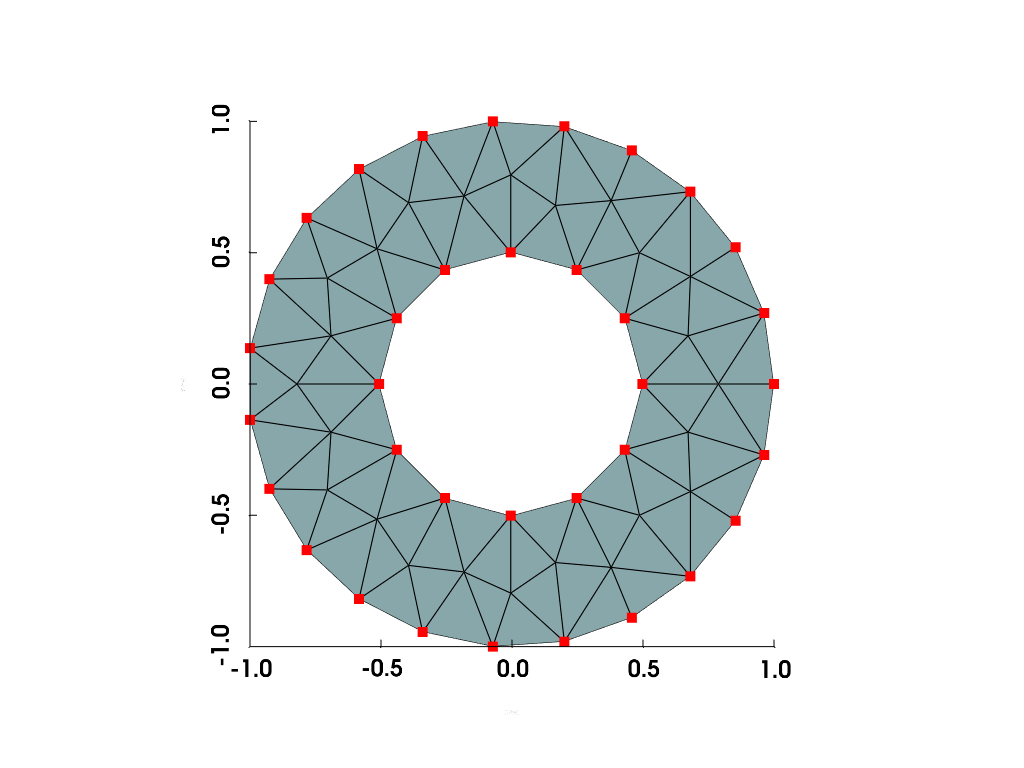

In [9]:
vtk_mesh = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(*vtk_mesh)
pl = pyvista.Plotter()
pl.add_mesh(grid, show_edges=True)
pl.add_points(grid.points[facets], point_size=10, color='red')
# pl.add_points(grid.points[outer_facets], point_size=10, color='blue')
pl.camera_position = 'xy'
pl.show_bounds()
pl.show()

Define the initial conditions:

- pressure: all 0
- velocity: all 0
- Q-tensor: director d perpendicular to the radial direction

In [10]:
p_n.x.array[:] = 0
u_n.x.array[:] = np.random.rand(u_n.x.array.size)

In [ ]:
# Get the mesh coordinates
x = domain.geometry.x  # shape (n_points, 2)
r = np.sqrt(x[:, 0]**2 + x[:, 1]**2)

# Avoid division by zero (if any points are at the origin)
r[r < 1e-10] = 1.0

# Compute the tangent (director) d = (-y, x)/|r|
d = np.column_stack((-x[:, 1], x[:, 0])) / r[:, None]

# Compute the Q-tensor: Q = S*(d⊗d - I/2)
Q_vals = np.einsum("ni,nj->nij", d, d) - 0.5 * np.eye(2)

# Reshape Q_vals to match the flattened dolfinx Function vector and set Q_n
Q_n.x.array[:] = Q_vals.flatten()

In [136]:
Q_n.x.array.shape

(236,)

In [142]:
d = np.random.rand(x.shape[0], 2)

In [147]:
d /= np.linalg.norm(d, axis=1, keepdims=True)

In [148]:
np.linalg.norm(d, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [137]:
x.shape

(59, 3)

In [118]:
F1 = (
    inner(nabla_grad(u), nabla_grad(v)) * dx
    - p * div(v) * dx
    + q * div(u) * dx
    + inner(div(Q_n), v) * dx
)

In [119]:
wall_dofs = fem.locate_dofs_geometrical(V_p, walls)
noslip = fem.dirichletbc(PETSc.ScalarType(0), wall_dofs, V_p)
bcu = [noslip]

In [120]:
a1 = fem.form(lhs(F1))
L1 = fem.form(rhs(F1))

In [121]:
# assemble matrix A and b
A1 = assemble_matrix(a1)
A1.assemble()
b1 = create_vector(L1)

In [122]:
# configure a solver for u
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

In [123]:
dt = 1

In [124]:
t = 0
t += dt
with b1.localForm() as loc_b:
    loc_b.set(0)
# b1.set(0)
assemble_vector(b1, L1)
apply_lifting(b1, [a1], [bcu])
b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
set_bc(b1, bcu)
solver1.solve(b1, w_.x.petsc_vec)

In [110]:
w_.x.array.shape

(461,)

In [125]:
p_sol, u_sol = w_.split()

In [126]:
u_.interpolate(u_sol)

In [132]:
uvis.interpolate(u_sol)

In [135]:
xdmf = io.XDMFFile(domain.comm, "annulus.xdmf", "w")
xdmf.write_mesh(domain)
xdmf.write_function(uvis, t)
xdmf.close()

In [111]:
u_.x.array.shape

(461,)

In [112]:
p_n.x.array.shape

(59,)

In [12]:
def q_to_director(Q):
    """
    Convert a Q-tensor (2x2 symmetric, traceless) of the form Q = S*(d⊗d - I/2)
    to the corresponding unit director d.
    
    Parameters:
      Q (numpy.ndarray): 2x2 Q-tensor.
    
    Returns:
      numpy.ndarray: Unit director, a vector of length 2.
    """
    Q11 = Q[0, 0]
    Q12 = Q[0, 1]
    norm = np.sqrt(Q11**2 + Q12**2)
    if norm < 1e-10:
        raise ValueError("Q-tensor magnitude is nearly zero; director is undefined.")
    theta = 0.5 * np.arctan2(Q12, Q11)
    d = np.array([np.cos(theta), np.sin(theta), 0])
    return d

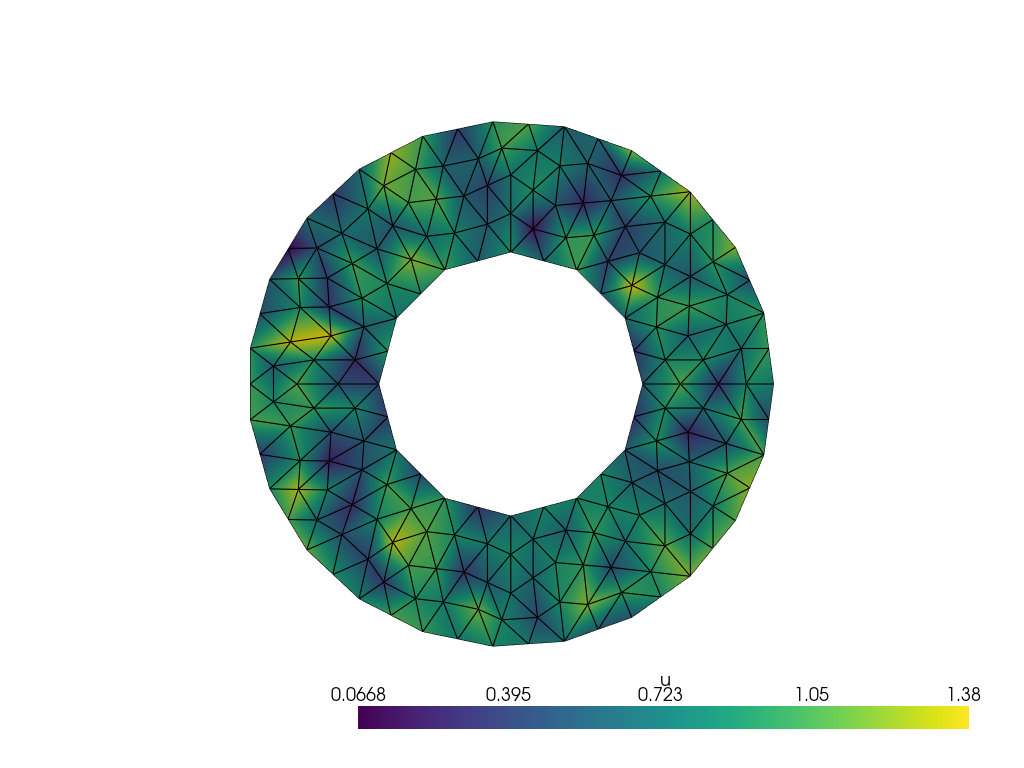

In [13]:
topology, cell_types, geometry = plot.vtk_mesh(V_u)
gridu = pyvista.UnstructuredGrid(topology, cell_types, geometry)
gridu.point_data["u"] = u_n.x.array.reshape((-1, 2))
pl = pyvista.Plotter()
pl.add_mesh(gridu, show_edges=True)
pl.camera_position = 'xy'
pl.show()

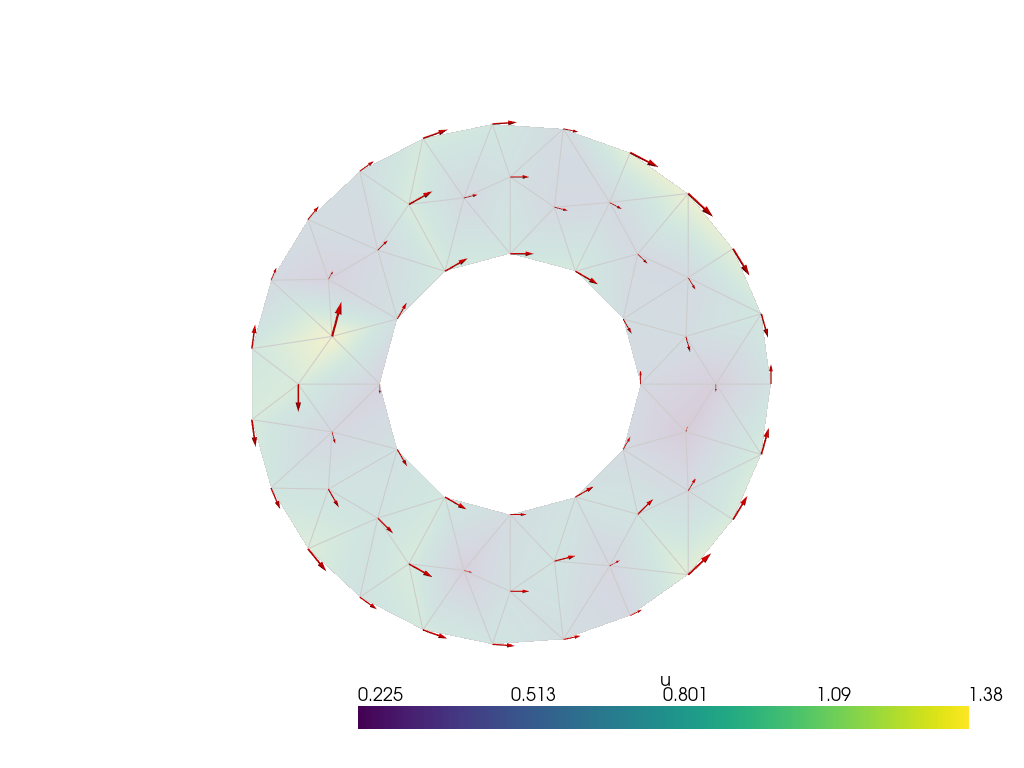

In [ ]:
# Reshape Q_n to get an array of 2x2 tensors (one per node)
Q_vals = Q_n.x.array.reshape(-1, 2, 2)

# Pad each 2x2 Q tensor to a 3x3 tensor (embed in the xy-plane)
Q_tensor_3d = np.zeros((Q_vals.shape[0], 3, 3))
Q_tensor_3d[:, :2, :2] = Q_vals

# Add Q tensor data to the existing grid as a flat 9-component array per point
grid.point_data["Q_tensor"] = np.array([q_to_director(Q) for Q in Q_vals])
V_u_vis = fem.functionspace(domain, ("Lagrange", 1, (2,)))
u_vis = fem.Function(V_u_vis)
u_vis.interpolate(u_n)
u_val = np.linalg.norm(u_vis.x.array.reshape(-1, 2), axis=1)
grid.point_data["u"] = u_val
grid.set_active_scalars("u")
grid.set_active_vectors("Q_tensor")
p.arctan2(Q12, Q11)

# Create tensor glyphs for visualization; adjust scale_factor as needed
glyphs = grid.glyph(factor=0.1)

# Plot the base mesh (with slight opacity) and overlay the glyphs
pl = pyvista.Plotter()
pl.add_mesh(grid, opacity=0.2, show_edges=True)
pl.add_mesh(glyphs, color="red")
pl.camera_position = 'xy'
pl.show()

In [141]:
domain.topology.create_connectivity(0, 2)

In [27]:
# p_dof = fem.locate_dofs_topological(V_p, 0, np.concat([inner_facets, outer_facets]))
# u_dof = fem.locate_dofs_topological(V_u, 0, np.concat([inner_facets, outer_facets]))
# q_dof = fem.locate_dofs_topological(V_Q, 0, np.concat([inner_facets, outer_facets]))
p_dof = fem.locate_dofs_geometrical(V_p, walls)
u_dof = fem.locate_dofs_geometrical(V_u, walls)
q_dof = fem.locate_dofs_geometrical(V_Q, walls)

In [28]:
u_bc = fem.dirichletbc(fem.Constant(domain, (0.0, 0.0)), u_dof, V_u)

In [12]:
# compute Qb to use as an implicit boundary condition in the variational form
n = FacetNormal(domain) # 'domain' is your mesh object
t_hat = as_vector((-n[1], n[0])) # Assuming 2D
I = Identity(domain.geometry.dim) # For 2D, this is a 2x2 identity tensor
Qb = outer(t_hat, t_hat) - 0.5 * I

In [13]:
T = 10
n_steps = 100
dt = T / n_steps

In [14]:
# Constants
alpha = fem.Constant(domain, PETSc.ScalarType(5.0))
mu = fem.Constant(domain, PETSc.ScalarType(1.0))
gamma = fem.Constant(domain, PETSc.ScalarType(1.0))
lambda_ = fem.Constant(domain, PETSc.ScalarType(0.7))
DE = fem.Constant(domain, PETSc.ScalarType(1.0))
Dr = fem.Constant(domain, PETSc.ScalarType(1.0))
beta1 = fem.Constant(domain, PETSc.ScalarType(0.6))
beta2 = fem.Constant(domain, PETSc.ScalarType((1.6 + 1.0) / (1.6**2)))
EA = fem.Constant(domain, PETSc.ScalarType(0.01))
k = fem.Constant(domain, PETSc.ScalarType(dt))

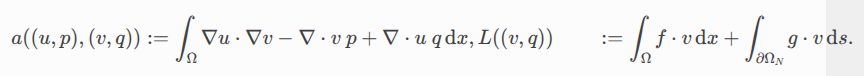

Combine the equations just by adding together

Weak form of the Stokes equation

$$
\int_\Omega (-\mu\nabla u:\nabla v + P\nabla\cdot v - \alpha (\nabla\cdot Q)\cdot v) \,d\Omega = 0
$$

$$
\int_\Omega (\nabla\cdot u) q \,d\Omega = 0
$$

$$
\left<-\mu\nabla u, \nabla v \right> + p\left<n, v\right>_{\partial\Omega} = \left< \alpha n\cdot Q, v\right>_{\partial\Omega}
$$

$$
q\left< n, u \right>_{\partial\Omega} = 0
$$

Weak form of the Q-tensor evolution

$$
\int_\Omega [\partial_t \mathbf{Q:\Phi} + (\mathbf{u}\cdot\nabla\mathbf{Q}):\Phi] \,d\Omega = \int_\Omega \left[ (\mathbf{Q\Omega - \Omega Q}):\mathbf{\Phi} + \lambda \mathbf{E:\Phi} + \gamma^{-1}\mathbf{H:\Phi}  \right] \,d\Omega
$$

$$
\gamma^{-1} H = D_r (b_1 - b_2 Q:Q)Q + D_E \nabla^2 Q - E_A (Q - Q^{b})|_{\partial \Omega}
$$

Use $u_*$ and $Q_*$ to denote the velocity and Q-tensor in the previous step.


$$
\int_\Omega  \frac{Q-Q_*}{\Delta t}:\Phi + u_*\cdot\nabla Q:\Phi \,d\Omega = \int_\Omega \left[ (\mathbf{Q\Omega_* - \Omega_* Q}):\mathbf{\Phi} + \lambda \mathbf{E:\Phi} + \gamma^{-1}\mathbf{H:\Phi}  \right] \,d\Omega
$$

Plug in $\gamma^{-1} H$

$$
\int_\Omega  \frac{Q-Q_*}{\Delta t}:\Phi + u_*\cdot\nabla Q:\Phi \,d\Omega = 
$$

$$
\int_\Omega \left[ (\mathbf{Q\Omega_* - \Omega_* Q}):\mathbf{\Phi} + \lambda \mathbf{E:\Phi} + D_r(b_1 - b_2 Q_*:Q_*)Q:\Phi - D_E(\nabla Q_*:\nabla \Phi) \right] \,d\Omega + \int_{\partial\Omega} E_A (Q-Q^b) \,d\partial\Omega
$$

Boundary conditions

$$
u = 0 \;\; \mathrm{for } \partial\Omega
$$

$$
Q^b = (\hat t\otimes \hat t - I/2) \;\; \mathrm{on } \partial \Omega
$$

In [ ]:
F1 = (
        - mu * inner(grad(u), grad(v))
        + p_n * div(v)
        # + q * div(u)
        - alpha * inner(div(Q_n), v)
    ) * dx


In [ ]:
a1 = fem.form(lhs(F1))
L1 = fem.form(rhs(F1))
A1 = assemble_matrix(a1, bcs=[u_bc])
A1.assemble()
b1 = create_vector(L1)

In [148]:
# Solver for step 1
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

In [149]:
solver1.solve(b1, u_n.x.petsc_vec)
u_n.x.scatter_forward()

In [ ]:
a = (ufl.inner(ufl.grad(u), ufl.grad(v)) - ufl.inner(P, ufl.div(v)) + ufl.inner(ufl.div(u), q)) * ufl.dx
L = alpha * ufl.inner(Q_nematic, ufl.grad(v)) * ufl.dx

# Appendix

## A. Only evolve Q-tensor

In [2]:
# Simulation parameters
T = 100
dt = 0.1

# Define simulation domain: load from .msh file
mesh_file = "annulus.msh"
domain, cell_tags, facet_tags = gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'annulus.msh'...
Info    : 5 entities
Info    : 2796 nodes
Info    : 5592 elements
Info    : Done reading 'annulus.msh'


In [3]:
# Define individual elements
u_el = element("Lagrange", domain.topology.cell_name(), 2, shape=(2,))
p_el = element("Lagrange", domain.topology.cell_name(), 1, shape=())
w_el = mixed_element([u_el, p_el])

# Define function spaces
W = fem.functionspace(domain, w_el)
V_Q = fem.functionspace(domain, ("Lagrange", 1, (2, 2)))
V_vis = fem.functionspace(domain, ("Lagrange", 1, (2,)))
V_u, _ = W.sub(0).collapse()
V_p, _ = W.sub(1).collapse()

In [4]:
u_n = fem.Function(V_u, name="velocity")
Q_ = fem.Function(V_Q)
Q_n = fem.Function(V_Q)
# Q_n.x.array[:] = Q_vals.flatten()
phi = TestFunction(V_Q)

In [5]:
u_el.reference_value_shape

(2,)

In [6]:
u_el.dim

12

In [7]:
alpha = fem.Constant(domain, PETSc.ScalarType(5.0))
mu = fem.Constant(domain, PETSc.ScalarType(1.0))
gamma = fem.Constant(domain, PETSc.ScalarType(1.0))
lambda_ = fem.Constant(domain, PETSc.ScalarType(0.7))
C = fem.Constant(domain, PETSc.ScalarType(1.0))
K = fem.Constant(domain, PETSc.ScalarType(10.0))
beta1 = fem.Constant(domain, PETSc.ScalarType(0.6))
beta2 = fem.Constant(domain, PETSc.ScalarType((1.6 + 1.0) / (1.6**2)))
EA = fem.Constant(domain, PETSc.ScalarType(0.1))
k = fem.Constant(domain, PETSc.ScalarType(dt))

In [8]:
u_grad = nabla_grad(u_n)
Omega = 0.5 * (u_grad + transpose(u_grad))
E = 0.5 * (u_grad - transpose(u_grad))
dFdQ_bulk1 = C * beta1 * Q_ + C * beta2 * inner(Q_, Q_) * Q_ 
dFdQ_bulk2 = K * inner(nabla_grad(Q_), nabla_grad(phi))
n = FacetNormal(domain)
Qb = outer(n, n) - 0.5 * Identity(domain.geometry.dim)
dFdQ_surf = EA * (Q_ - Qb)

F2 = (
    inner((Q_ - Q_n) / k, phi) * dx
    + inner(dot(u_n, nabla_grad(Q_)), phi) * dx
    - inner(Q_*Omega - Omega*Q_, phi) * dx
    - inner(lambda_ * E, phi) * dx
    - inner(dFdQ_bulk1 / gamma, phi) * dx
    + dFdQ_bulk2 * dx
    - inner(dFdQ_surf / gamma, phi) * ds
)

In [9]:
# random initial Q-tensor
# Get the mesh coordinates
x = domain.geometry.x  # shape (n_points, 2)
r = np.sqrt(x[:, 0]**2 + x[:, 1]**2)

# Avoid division by zero (if any points are at the origin)
r[r < 1e-10] = 1.0

# Compute the tangent (director) d = (-y, x)/|r|
d = np.column_stack((-x[:, 1], x[:, 0])) / r[:, None]

# Compute the Q-tensor: Q = S*(d⊗d - I/2)
Q_vals = np.einsum("ni,nj->nij", d, d) - 0.5 * np.eye(2)

# Reshape Q_vals to match the flattened dolfinx Function vector and set Q_n
Q_n.x.array[:] = Q_vals.flatten()

In [10]:
# jacobian
J = derivative(F2, Q_)

In [11]:
problem = NonlinearProblem(F2, Q_, J=J)
solver = NewtonSolver(domain.comm, problem)

In [12]:
import ufl
expr = ufl.as_vector([Q_n[0, 0], Q_n[0, 1]])
expr_interp = fem.Expression(expr, V_vis.element.interpolation_points())
Q2 = fem.Function(V_vis)
Q2.interpolate(expr_interp)

In [13]:
t = 0.0

with io.XDMFFile(domain.comm, "annulus.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    while t < T:
        # Update time-dependent coefficients here (e.g., source term)
        print(t, end="\r")

        # Update for next step
        Q2.interpolate(expr_interp)
        xdmf.write_function(Q2, t)
        Q_n.x.array[:] = Q_.x.array
        # Q_n.x.scatter_forward()
        t += dt

        # Solve nonlinear system
        n, converged = solver.solve(Q_)

RuntimeError: Newton solver did not converge because maximum number of iterations reached

In [43]:
# Update
dt

0.01